I'm gonna overwrite a lot of this notebook's old content. I changed the way I'm calculating wt, and wanna test that my training worked. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pearce.emulator import OriginalRecipe, ExtraCrispy
from pearce.mocks import cat_dict
import numpy as np
from os import path

In [3]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [4]:
import treecorr

In [5]:
training_file = '/u/ki/swmclau2/des/wt_trainer3/PearceRedMagicChinchillaWT.hdf5'
#training_file = '/u/ki/swmclau2/des/ds_trainer2/PearceRedMagicChindhillaDS.hdf5'


em_method = 'gp'
split_method = 'random'

In [6]:
a = 0.81120
z = 1.0/a - 1.0


In [7]:
fixed_params = {'z':z}#, 'r':0.18477483}

In [8]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params, independent_variable=None,\
                     custom_mean_function = "linear", downsample_factor = 1.0)

In [9]:
emu.get_param_names()

['logM1', 'logMmin', 'f_c', 'logM0', 'sigma_logM', 'alpha', 'r']

In [10]:
chain = np.genfromtxt('/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_wtheta_exp2_hyperparams.npy')
#chain = np.genfromtxt('/u/ki/swmclau2/des/PearceMCMC/200_walkers_1000_steps_delta_sigma_exp2_hyperparams.npy')

#v = chain.mean(axis = 0)
n_burn =  750
v = chain[200*n_burn:,].mean(axis = 0)

In [11]:
emu._emulator.set_parameter_vector(v)

In [12]:
x, y, yerr = emu.x, emu.y, emu.yerr

In [13]:
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from scipy import optimize

In [14]:
np.max(x, axis = 0)*2

array([ 3.46059134,  3.46057936,  3.46039485,  3.4606093 ,  3.46051319,
        3.46039974,  3.29496076])

0 1


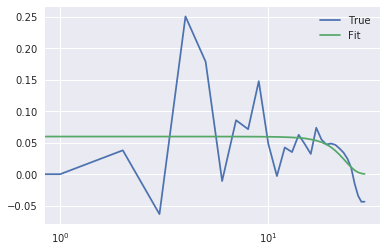

0 2


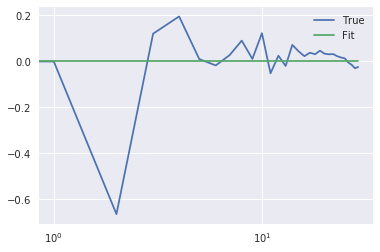

0 3


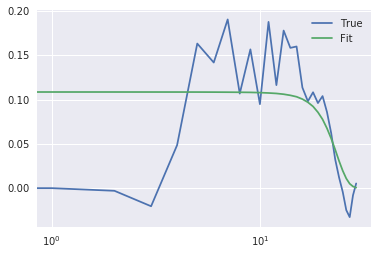

0 4


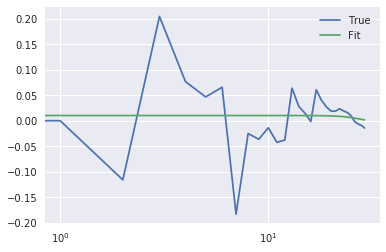

0 5


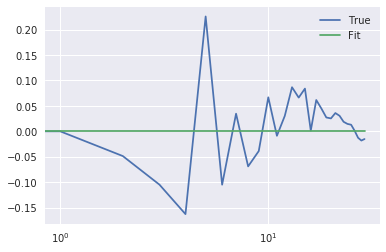

0 6


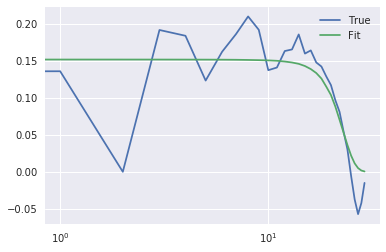

1 2


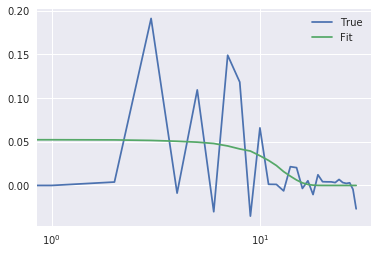

1 3


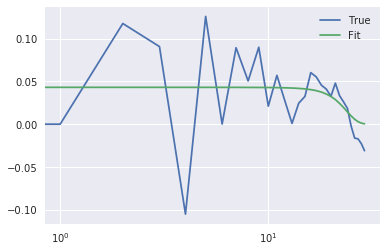

1 4


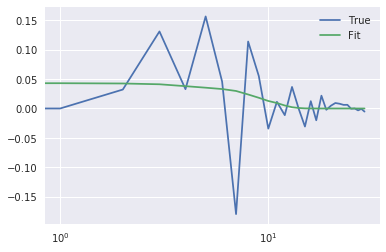

1 5


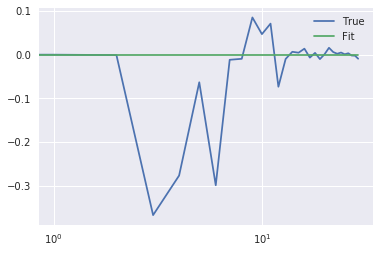

1 6


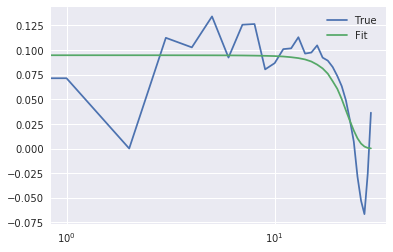

2 3


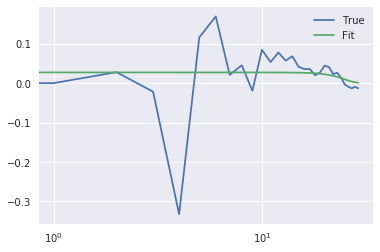

2 4


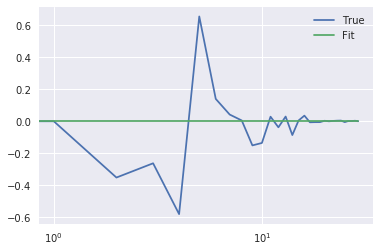

2 5


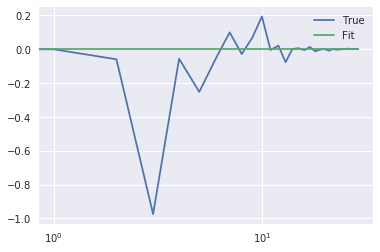

2 6


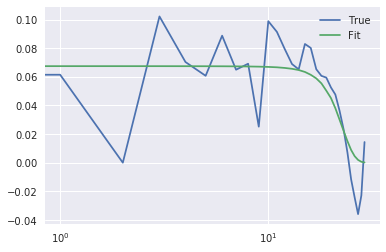

3 4


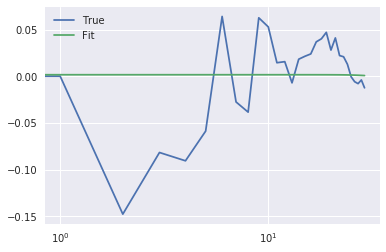

3 5


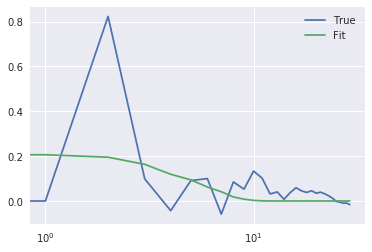

3 6


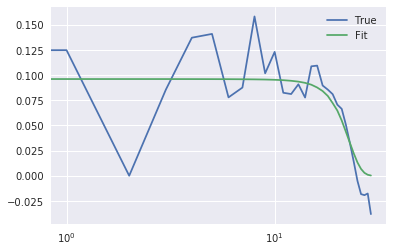

4 5


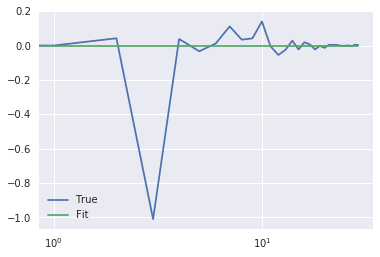

4 6


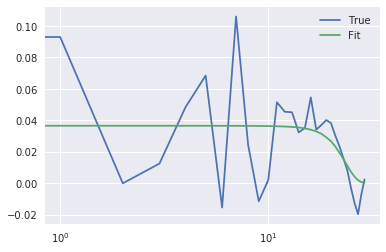

5 6


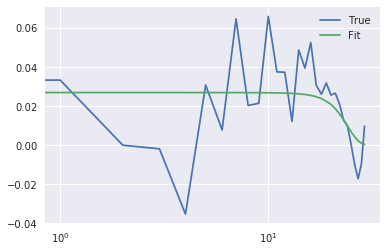

In [15]:
fit_results = [[] for i in xrange(x.shape[1]+1)]

for idx1 in xrange(x.shape[1]):
    for idx2 in xrange(idx1+1, x.shape[1]):
        #for idx3 in xrange(idx2, x.shape[1]):
        print idx1, idx2#, idx3

        size_x = np.max(x[:,idx1]) - np.min(x[:,idx1])
        size_y = np.max(x[:,idx2]) - np.min(x[:,idx2])
        #size_z = np.max(x[:, idx3]) - np.min(x[:,idx3])
        rho = float(len(x[:,idx1])) / (size_x * size_y)#* size_z)
        MIN = 5e-3
        MAX = 3.4 #np.sqrt(size_x**2 + size_y**2 )/2.#+ size_z**2)/2.
        
        #print MIN, MAX

        w = 1./yerr**2

        cat = treecorr.Catalog(x=x[:,idx1], y=x[:,idx2], k=(y-y.mean())/y.std(), w=w)
        kk = treecorr.KKCorrelation(min_sep=MIN, max_sep=MAX, nbins=30)
        kk.process(cat)

        distance = kk.meanr
        Coord = np.array([distance,np.zeros_like(distance)]).T

        vv = np.exp(v)
        kernel = ConstantKernel(vv[0])*Matern(np.array([vv[idx1+1], vv[idx2+1]]))# + ConstantKernel(vv[-1])

        def PCF(param, k=kernel):
            kernel =  k.clone_with_theta(param)
            pcf = kernel.__call__(Coord,Y=np.zeros_like(Coord))[:,0]
            return pcf

        def chi2(param, disp=np.std(y)):
            residual = kk.xi - PCF(param)
            var = disp**2
            return np.sum(residual**2/var)

        p0 = kernel.theta

        results_bfgs = optimize.minimize(chi2,p0,method="Powell")

        results =  results_bfgs['x']

        fit_results[0].append(results[0])
        #fit_results[1].append(results[-1])

        fit_results[idx1+1].append(results[1])
        fit_results[idx2+1].append(results[2])
        #fit_results[idx3+1].append(results[3])

        plt.plot(kk.xi, label = 'True')
        #plt.plot(PCF(np.exp(np.array([v[0], v[idx1+1], v[idx2+1], v[idx3+1], v[-1]])) ), label = 'Fit')
        plt.plot(PCF(results_bfgs['x']), label = 'Fit')

        plt.legend(loc='best')
        plt.xscale('log')
        plt.show()


In [16]:
fit_v = np.zeros((len(fit_results)))
for i, fr in enumerate(fit_results):
    fit_v[i] = np.median(fr)

#emu._emulator.set_parameter_vector(fit_v)

In [17]:
emu._emulator.parameter_vector

array([  0.        , -27.40787756,   0.03724262,  -2.34380573,
         1.79169344,   1.13961784,   1.95093754,  -0.13970449,
         4.76979911,   5.44836358,  -0.18179424])

In [18]:
print v
print fit_v

[ 0.03724262 -2.34380573  1.79169344  1.13961784  1.95093754 -0.13970449
  4.76979911  5.44836358 -0.18179424]
[ -3.30816696   0.07390724  -0.38479646  21.99227412   4.071678
  10.41866251  33.97536746  16.40068613]


In [19]:
from sklearn.model_selection import train_test_split
#downsample_idxs = np.random.choice(x.shape[0], size = int(x.shape[0]), replace = False)
#x,y, yerr = x[downsample_idxs, :], y[downsample_idxs], yerr[downsample_idxs]
test_size = 0.1

n_points = y.shape[0]/len(emu.scale_bin_centers)
n_test_points = int(n_points*(1-test_size))*len(emu.scale_bin_centers)

train_x, test_x, train_y, test_y, train_yerr, test_yerr = emu.x[:n_test_points], emu.x[n_test_points:],\
                                                          emu.y[:n_test_points], emu.y[n_test_points:],\
                                                          emu.yerr[:n_test_points], emu.yerr[n_test_points:]


#train_x, test_x, train_y, test_y, train_yerr, test_yerr = train_test_split(x, y, yerr, test_size = 0.1)
#train_x, test_x, train_y, test_y, train_yerr, test_yerr = emu.x, emu.x, emu.y, emu.y, emu.yerr, emu.yerr

In [20]:
from george.kernels import *
from george import GP

In [21]:
fit_kernel = np.exp(fit_v[0]) * Matern32Kernel(np.exp(fit_v[1:]), ndim=emu.emulator_ndim)# + np.exp(fit_v[1])

model = GP(fit_kernel)
model.compute(train_x, train_yerr)

In [22]:
pred_y = model.predict(train_y, test_x, False, False, False)*emu._y_std + emu._y_mean

In [23]:
pred_y+= emu.mean_function(test_x)
test_y+= emu.mean_function(test_x)

In [24]:
emu.mean_function(test_x)

array([ 1.84822767,  1.73866153,  1.6290954 , ...,  0.62865431,
        0.51908816,  0.40952201])

In [25]:
pred_y.shape, test_y.shape

((2000,), (2000,))

In [26]:
from seaborn import jointplot

In [27]:
pred_y

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


array([ 1.86617207,  1.75982676,  1.65348147, ...,  1.28431099,
        1.17523837,  1.0661657 ])

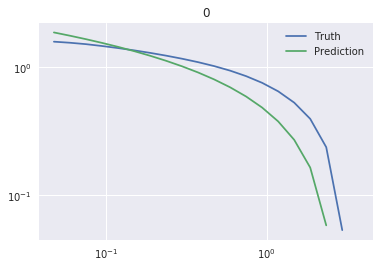

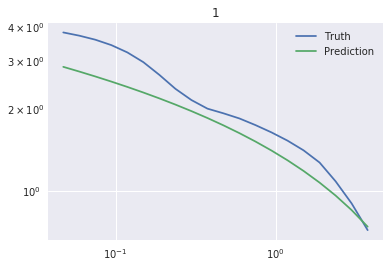

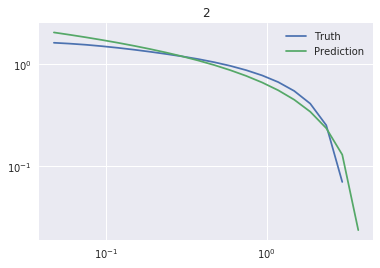

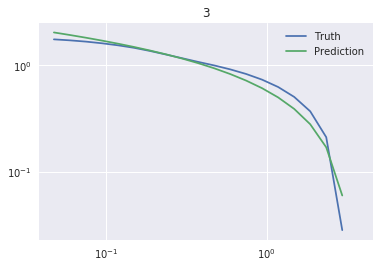

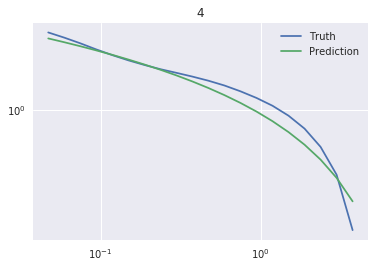

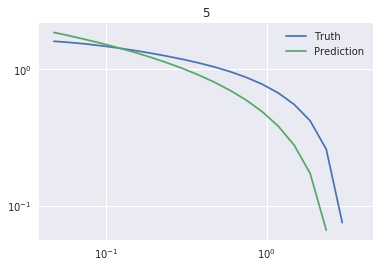

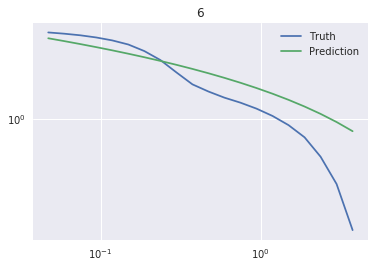

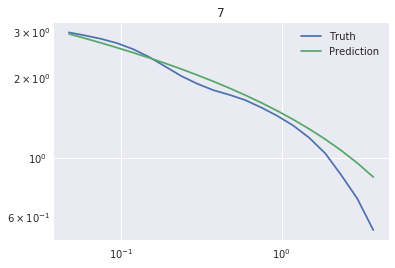

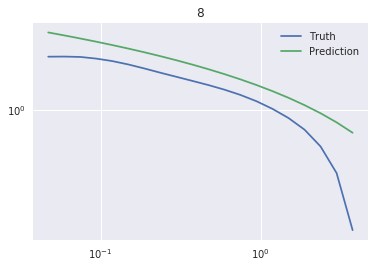

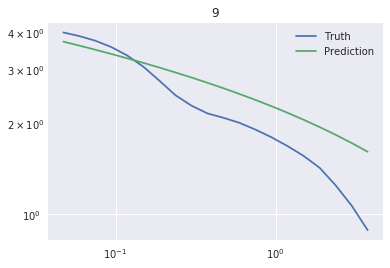

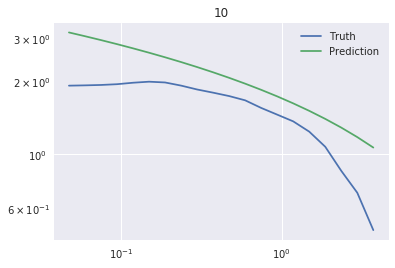

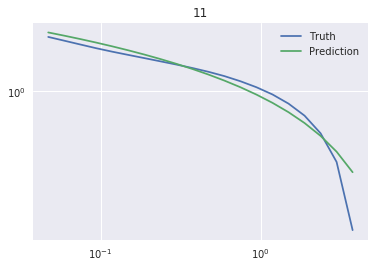

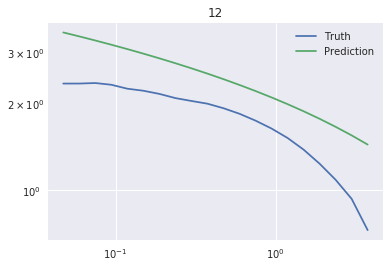

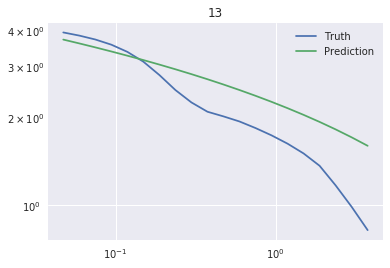

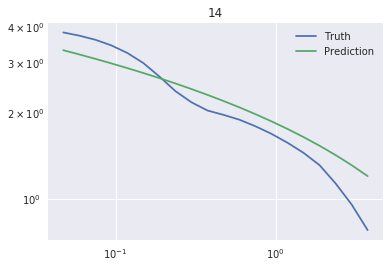

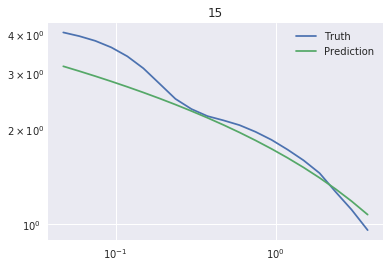

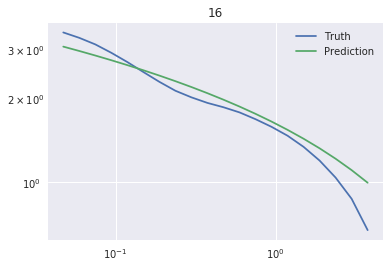

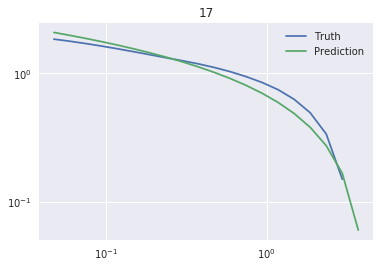

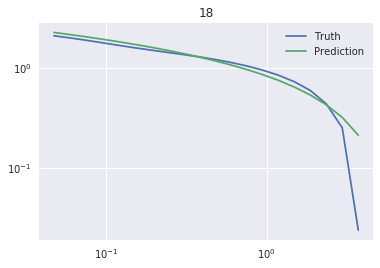

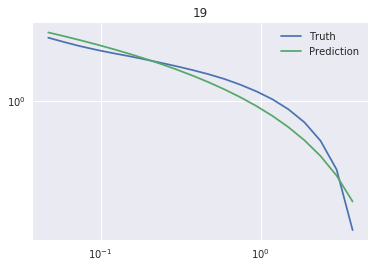

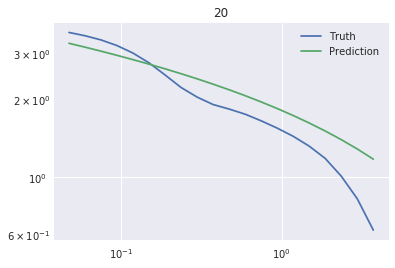

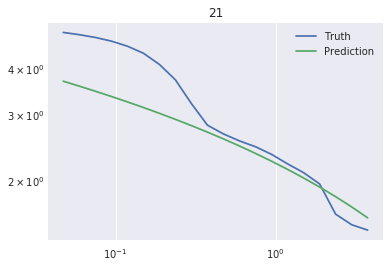

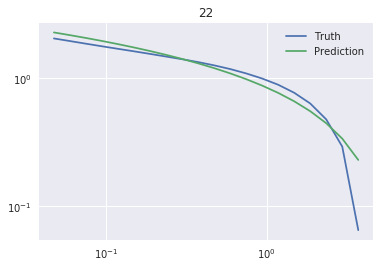

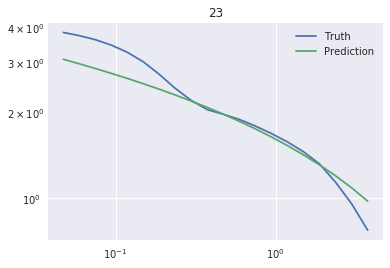

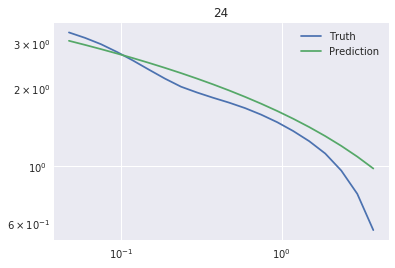

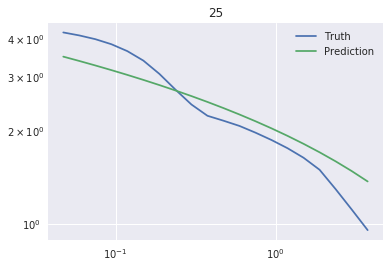

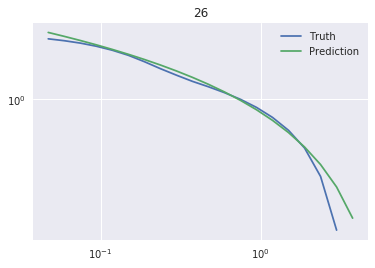

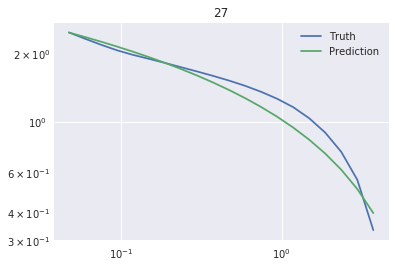

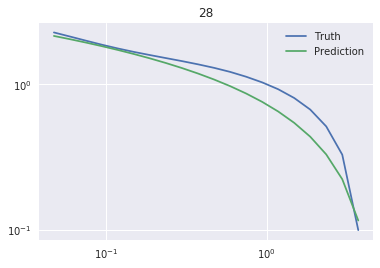

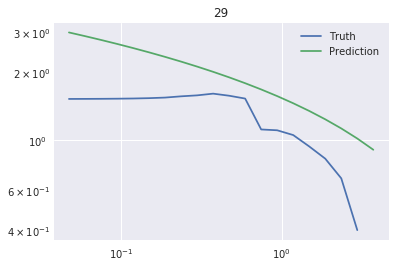

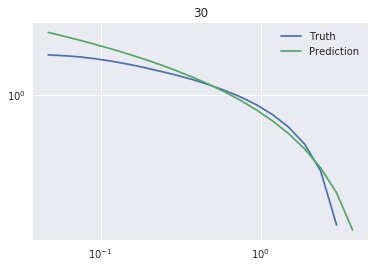

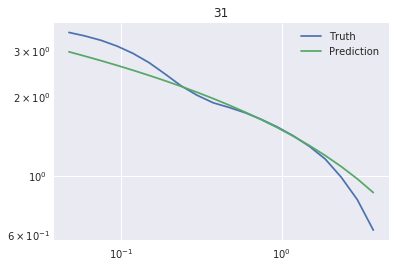

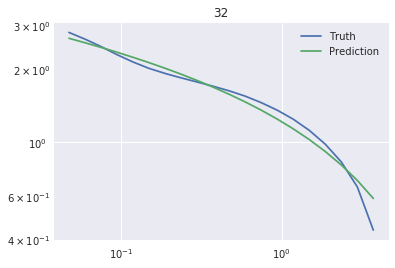

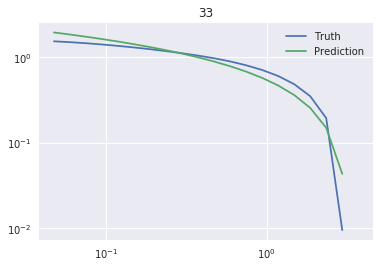

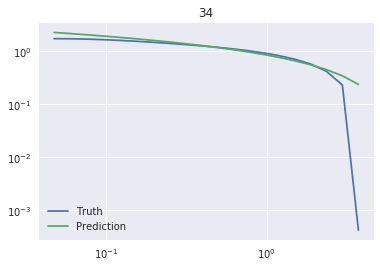

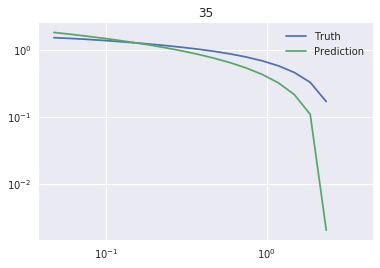

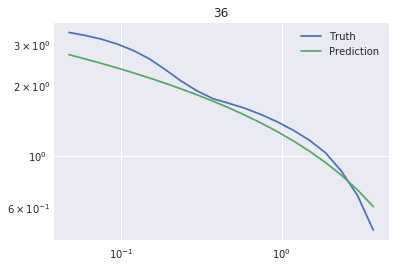

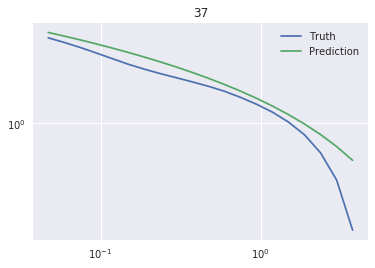

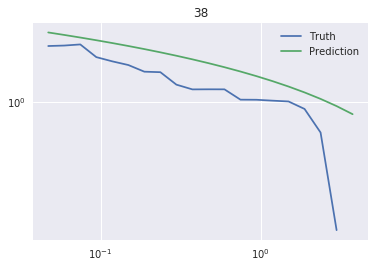

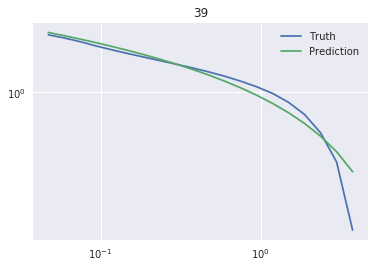

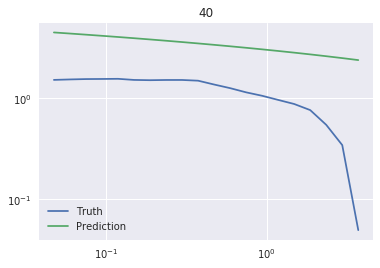

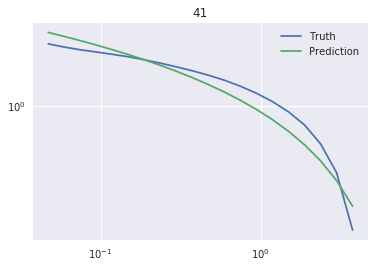

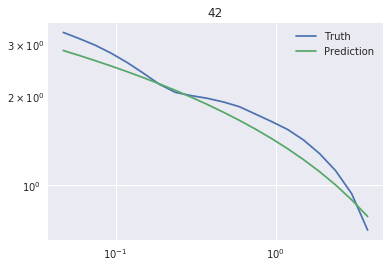

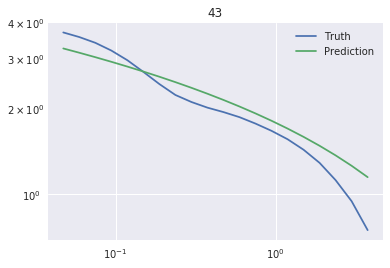

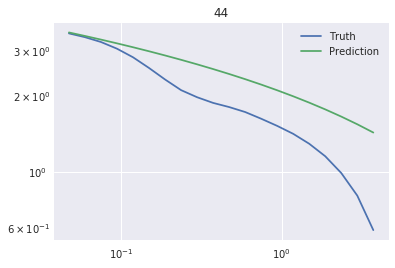

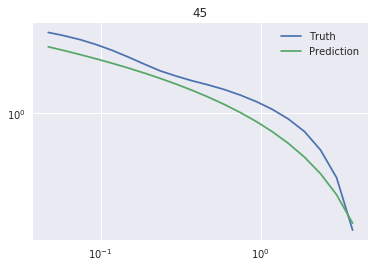

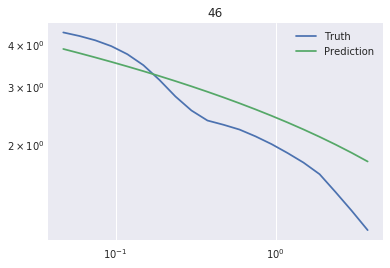

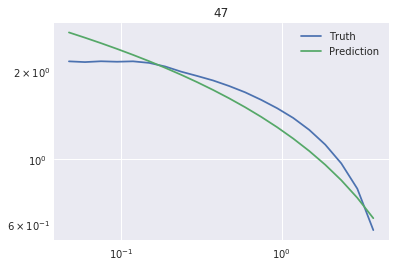

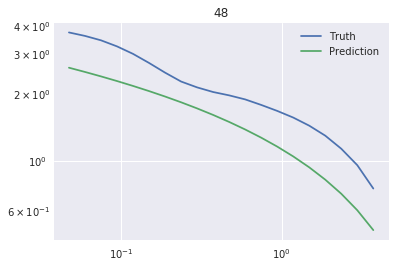

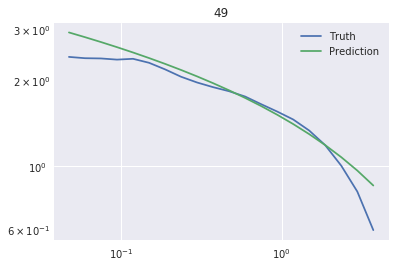

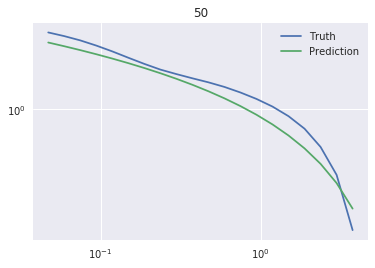

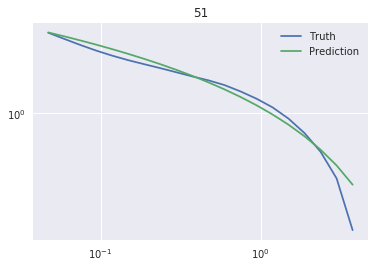

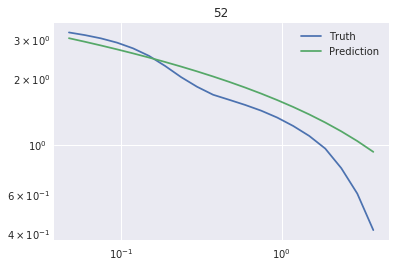

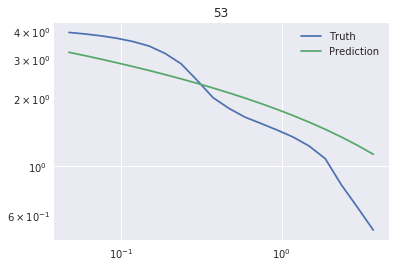

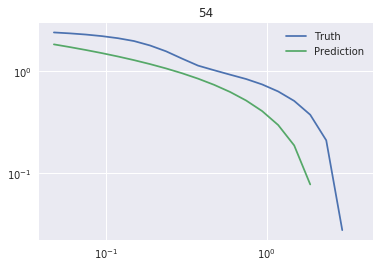

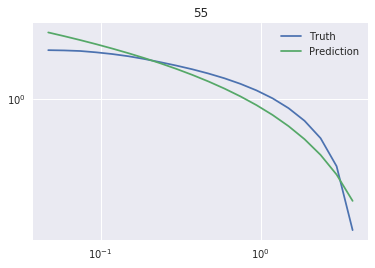

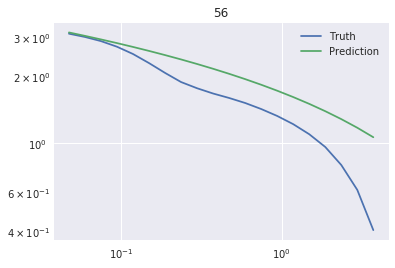

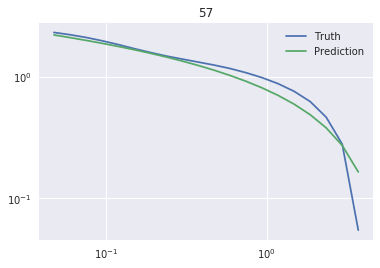

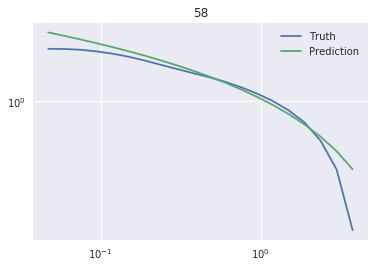

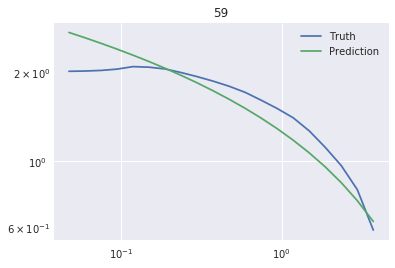

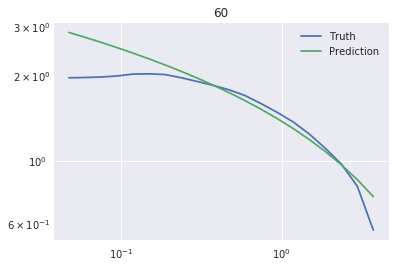

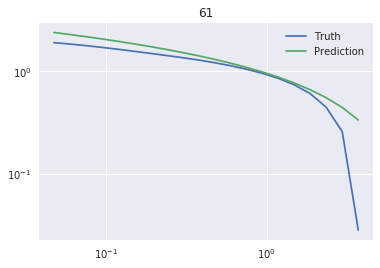

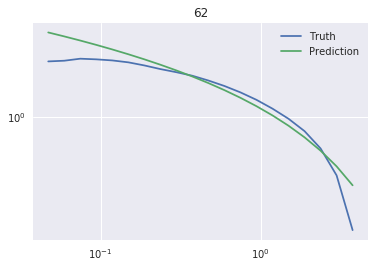

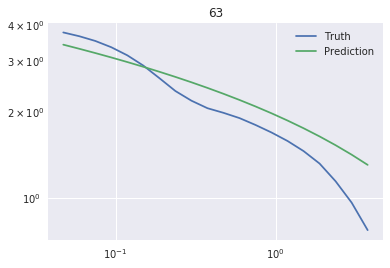

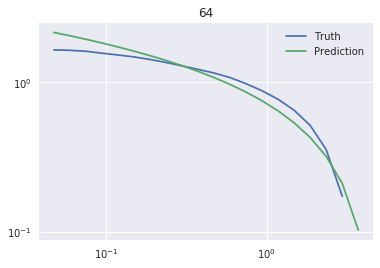

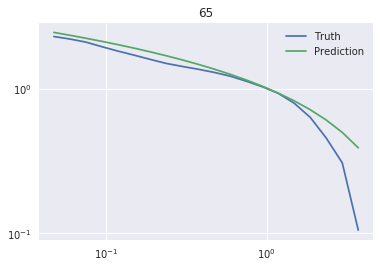

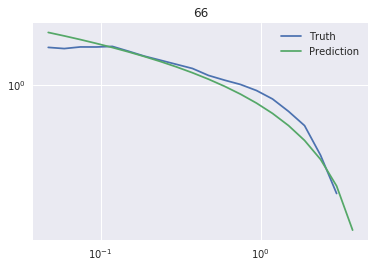

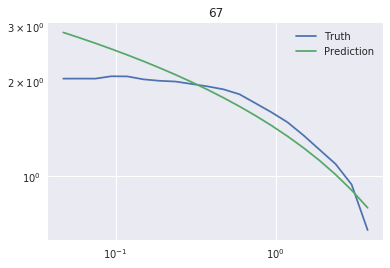

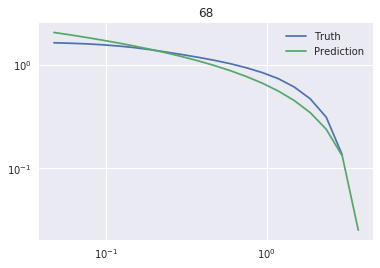

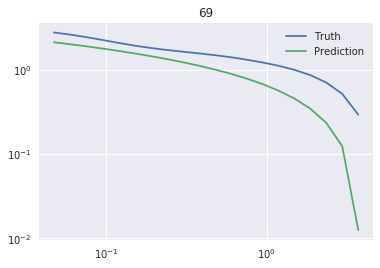

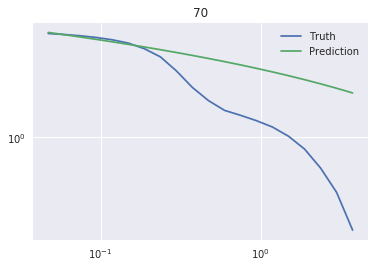

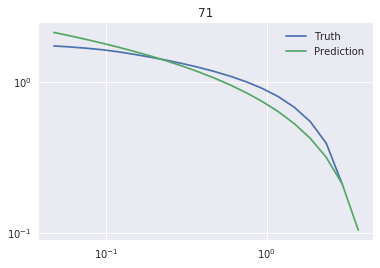

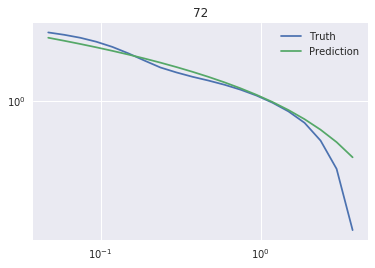

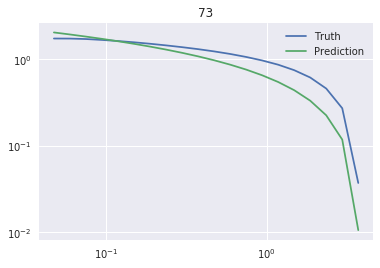

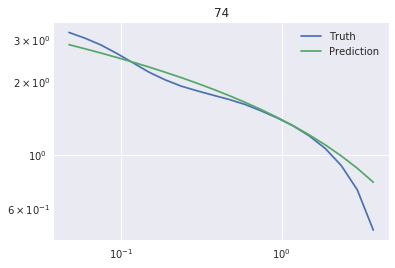

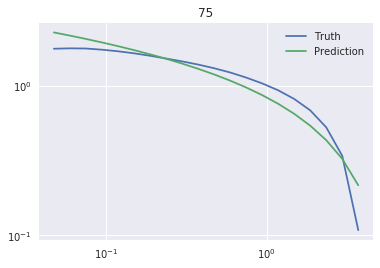

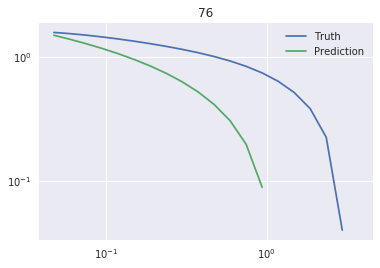

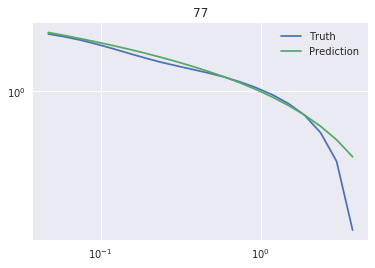

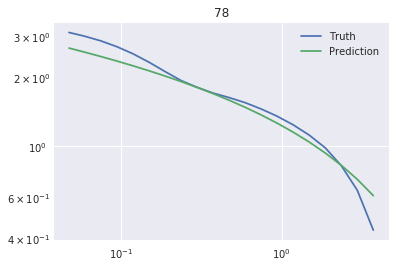

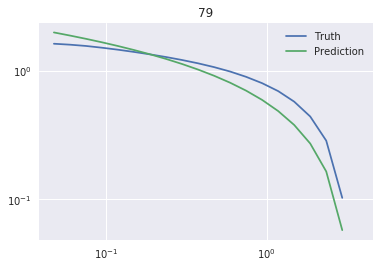

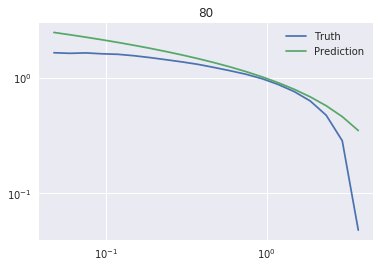

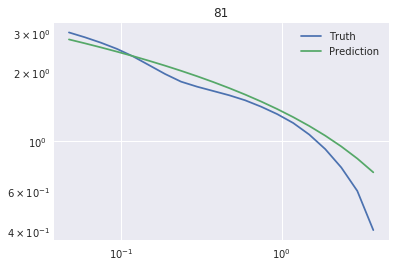

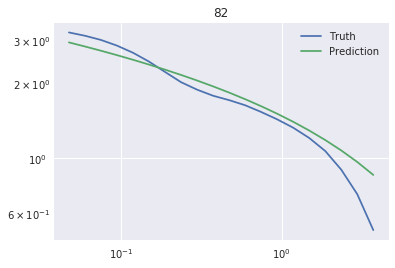

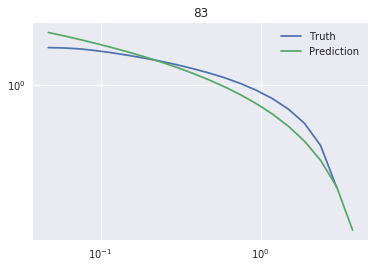

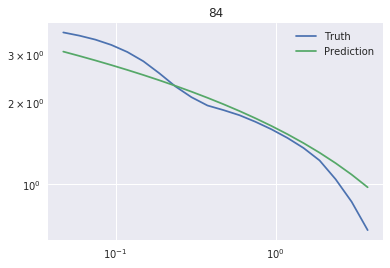

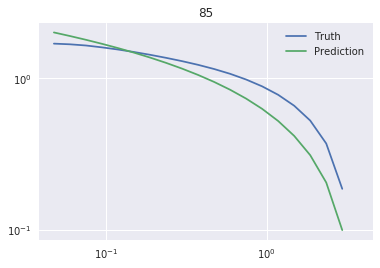

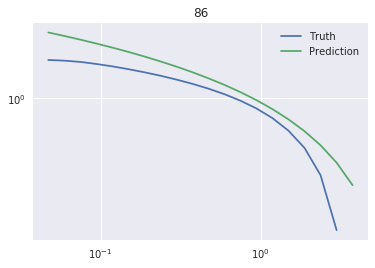

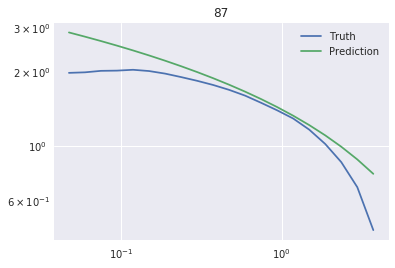

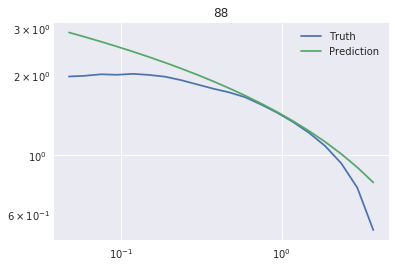

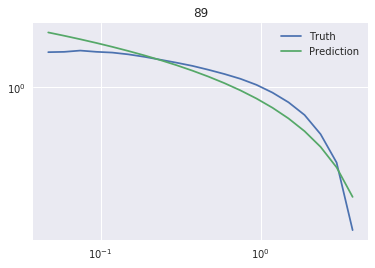

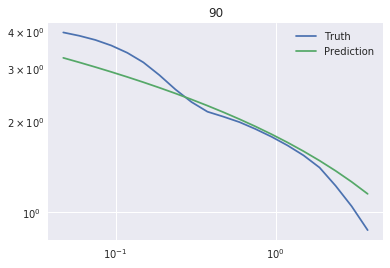

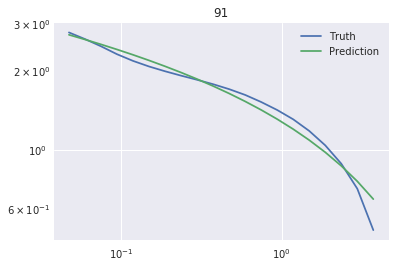

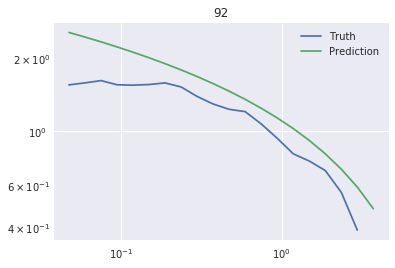

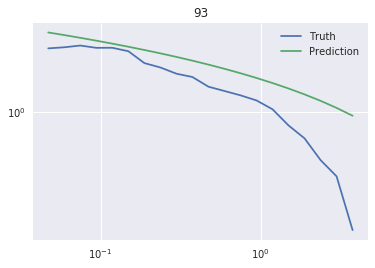

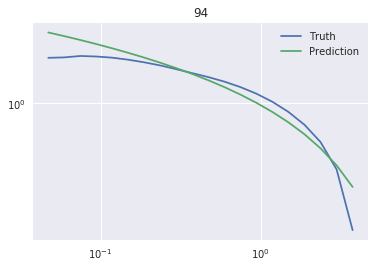

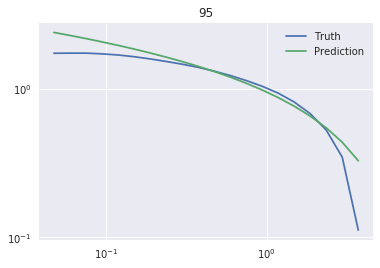

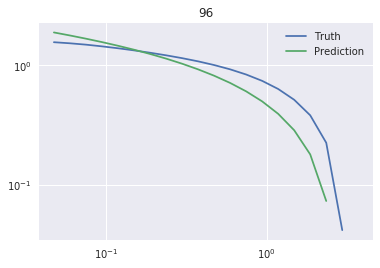

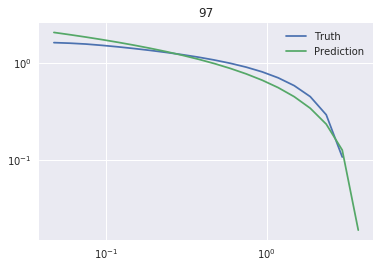

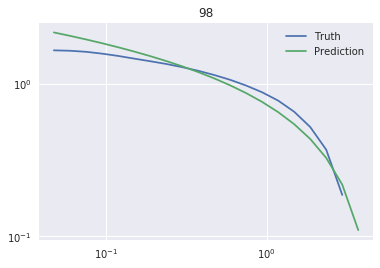

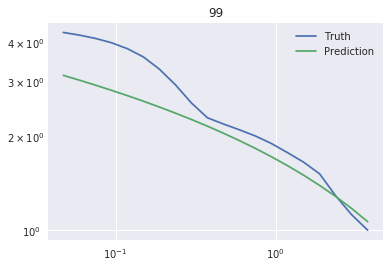

In [28]:
for i in xrange(pred_y.shape[0]/emu.n_bins):
    plt.plot(emu.scale_bin_centers, test_y[i*emu.n_bins:(i+1)*emu.n_bins], label = 'Truth')
    plt.plot(emu.scale_bin_centers, pred_y[i*emu.n_bins:(i+1)*emu.n_bins], label = 'Prediction')
    plt.loglog()
    plt.legend(loc='best')
    plt.title("%d"%i)
    plt.show()

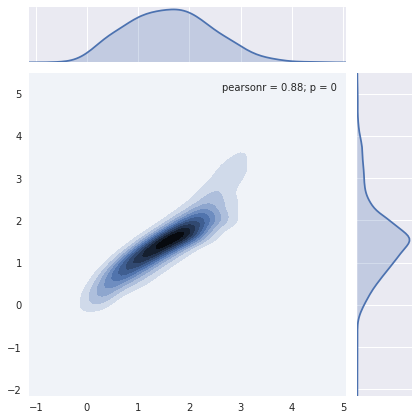

In [29]:
sns.jointplot(pred_y, test_y, kind = 'kde')


In [30]:
idxs =  np.argsort(np.abs((10**pred_y-10**test_y)/10**test_y))

In [31]:
np.mean(np.abs((pred_y-test_y)/test_y))
#np.mean(np.abs((pred_y-train_y)/train_y))

0.58291130234651956

In [32]:
np.mean(np.abs((10**pred_y-10**test_y)/(10**test_y)))

3.4541236452975674

In [33]:
np.median(np.abs((10**pred_y-10**test_y)/(10**test_y)))

0.36842470441287256

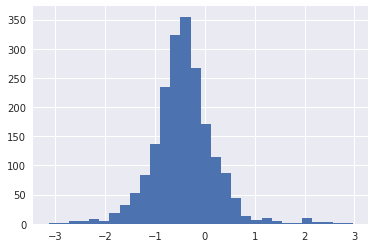

In [34]:
plt.hist(np.log10(np.abs((10**pred_y-10**test_y)/10**test_y)), bins = 30);